In [ ]:
!pip install youtube-transcript-api

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### **API 키 설정**

In [1]:
import os

os.environ['OPENAI_API_KEY'] = "YOUR_OPENAI_API_KEY"
os.environ['TAVILY_API_KEY'] = "YOUR_TAVILY_API_KEY"
os.environ["WOLFRAM_ALPHA_APPID"] = "WOLFRAM_ALPHA_APPID"

#### **WolframAlpha API 활용을 위한 비동기 설정**

In [2]:
import asyncio
asyncio.set_event_loop_policy(asyncio.DefaultEventLoopPolicy())

import nest_asyncio
nest_asyncio.apply()

In [3]:
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
wolfram = WolframAlphaAPIWrapper()

#### **focus 키 값을 포함한 State 설정**

In [4]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    focus: Literal["web", "academic", "video, math"]

#### **웹 검색, 논문 검색, 수학 계산 도구 정의** 

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import YouTubeSearchTool
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
import re

web_tool = TavilySearchResults(max_results=2)

@tool
def academic_tool(query:str):
    """
    academic paper search tool
    """
    arxiv = ArxivAPIWrapper()
    docs = arxiv.run(query)
    return docs

@tool
def math_tool(query:str):
    """
    math tool
    """
    wolfram = WolframAlphaAPIWrapper()
    result = wolfram.run(query)
    return result

In [6]:
academic_tool.run("AI 에이전트")

"Published: 2024-08-26\nTitle: AI Thinking: A framework for rethinking artificial intelligence in practice\nAuthors: Denis Newman-Griffis\nSummary: Artificial intelligence is transforming the way we work with information\nacross disciplines and practical contexts. A growing range of disciplines are\nnow involved in studying, developing, and assessing the use of AI in practice,\nbut these disciplines often employ conflicting understandings of what AI is and\nwhat is involved in its use. New, interdisciplinary approaches are needed to\nbridge competing conceptualisations of AI in practice and help shape the future\nof AI use. I propose a novel conceptual framework called AI Thinking, which\nmodels key decisions and considerations involved in AI use across disciplinary\nperspectives. The AI Thinking model addresses five practice-based competencies\ninvolved in applying AI in context: motivating AI use in information processes,\nformulating AI methods, assessing available tools and technol

In [ ]:
math_tool.run("123*123^2")

#### **Video 검색 도구 정의하기**

In [8]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import YouTubeSearchTool
from langchain_community.document_loaders import YoutubeLoader
from langchain_core.documents import Document
import ast

youtube_search_tool = YouTubeSearchTool()


@tool
def video_tool(query:str) -> str:
    """
    Retriever tool for the transcript of a YouTube video.
    If user want to find some information, this tool is good to gather youtube video information.
    query should be given in string format.
    """
    #query에 해당하는 Youtube 비디오 URL 가져오기
    urls = youtube_search_tool.run(query)
    urls = ast.literal_eval(urls)
    #URL 순회하면서 Document 객체에 내용 담기
    docs = []
    for url in urls:
        loader = YoutubeLoader.from_youtube_url(
        url,
        add_video_info=True,
        language=["en", "ko"]
        )
        scripts = loader.load()
        script_content = scripts[0].page_content
        title=scripts[0].metadata['title']
        author=scripts[0].metadata['author']
        doc = Document(page_content=script_content, metadata={"source": url, "title":title, "author":author})
        docs.append(doc)

    #모든 비디오의 내용을 벡터DB에 담기
    text_splitter = RecursiveCharacterTextSplitter(
        separators  = ["\n\n", "\n", ".", ",", " ", ""],
        chunk_size=1000, 
        chunk_overlap=0)
    texts = text_splitter.split_documents(docs)
    embeddings = OpenAIEmbeddings()
    db = Chroma.from_documents(texts, embeddings)
    retriever = db.as_retriever()
    retrieved_docs = retriever.invoke(query)

    video_results = []

    for doc in retrieved_docs:
        title = doc.metadata.get('title', 'No title available')
        author = doc.metadata.get('author', 'No author available')
        script_content = doc.page_content

        video_info = f"""
        Video Information:
        ------------------
        Title: {title}
        Author: {author}
        Transcript:
        {script_content}
        ------------------
        """
        video_results.append(video_info)

    # Join all video results into a single string
    all_video_results = "\n\n".join(video_results)

    return all_video_results

In [ ]:
video_tool.run("테디노트가 누구야?")

#### **각 도구를 개별 ToolNode로 설정**

In [10]:
tools = {
    "web": [web_tool],
    "academic": [academic_tool],
    "video": [video_tool],
    "math":[math_tool]
}

tool_nodes = {focus: ToolNode(tools[focus]) for focus in tools}

In [11]:
tool_nodes

{'web': tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}, tool_to_state_args={'tavily_search_results_json': {}}, tool_to_store_arg={'tavily_search_results_json': None}, handle_tool_errors=True, messages_key='messages'),
 'academic': tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'academic_tool': StructuredTool(name='academic_tool', description='academic paper search tool', args_schema=<class 'langchain_core.utils.pydantic.academic_tool'>, func=<function academic_tool at 0x113046480>)}, tool_to_state_args={'academic_tool': {}}, tool_to_store_arg={'academic_tool': None}, handle_tool_errors=True, messages_key='messages'),
 'video': tools(tags=None, recurse=True, ex

#### **Chatbot 설정**

In [12]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    llm_with_tools = llm.bind_tools(tools[state["focus"]])
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

#### **그래프 구축**

In [13]:
from langgraph.graph import StateGraph, END

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

for focus, tool_node in tool_nodes.items():
    graph_builder.add_node(f"{focus}_tools", tool_node)

def focus_condition(state):
    if state["messages"][-1].tool_calls:
        return f"{state['focus']}_tools"
    return END  # END 상수 사용

graph_builder.add_conditional_edges(
    "chatbot",
    focus_condition,
    {
        "web_tools": "web_tools",
        "academic_tools": "academic_tools",
        "video_tools": "video_tools",
        "math_tools": "math_tools",
        END: END
    }
)

for focus in tools:
    graph_builder.add_edge(f"{focus}_tools", "chatbot")

graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

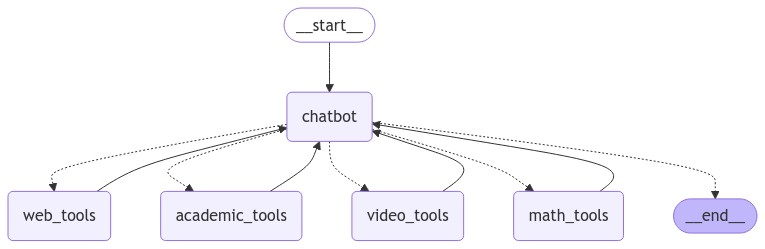

In [171]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# example with a multiple tool calls in succession

for chunk in graph.stream({
        "messages": [{"role": "user", "content": "AI 에이전트에는 어떤 프레임워크가 있어?"}],
        "focus": "video"
    },
    stream_mode="values",
):
    print(chunk['messages'][-1].content)